# Quantile Optimal Treatment Regime


##   Motivation

Aside from evaluating the performance of a target policy or finding the optimal treatment regimes with respect to the **mean outcome**, it is natural to extendour goal to exploring the whole reward distribution. The easiest way to conduct policy evaluation and optimization is to estimate the quantiles with respect to some quantile levels in $[0,1]$. There are some cases when it is not satisfactory to only evaluate the mean outcome:



1.   **The problem of our interest may not be limited to the mean reward**: For example, when evaluating the performance of a certain policy in prolonging customers watching time on a video platform, one may be interested in how well the policy is in stimulating the customers at the lower 25% tail, so as to improve the overall prevalence of this platform and attract more potential customers.

2.   **Heavy tails**: In the case when the reward distribution is naturally heavy-tailed, the performance of directly estimating the mean outcome (or doing optimization) may be very unstable. In this case, we may want to know the whole picture of the outcome distribution in order to do further statistical inferences.
3.   **Skewed distribution**: For example, in the cases when we would like to evaluate the survival time of patients, it may be desirable to consider the treatment regime that maximizes the median of the distribution of the potential outcome.


Note: the recent work on discrete Q-learning in [Moodie et al. (2014) [2]](https://link.springer.com/article/10.1007/s12561-013-9103-z) can be applied to first estimate the probabilities and then invert them to estimate quantiles, but simply taking the inverse to the cummulative density function may cause a lot of potential problems to the qunatile estimation and optimization. 







## Main Idea

In recent years, there are more work focusing on quantile estimating the optimal treatment regime in order to maximize the qunatile at level $\tau$ given a class of feasible treatment regimes $\mathbb{D}=\{I(X^T\beta>0:\beta\in \mathbb{B})\}$. That is, the objective function is to maximize
   $$\arg\max_{d\in \mathbb{D}}Q_{\tau}(Y^*(d)),$$
where $Q_{\tau}$ denotes the quantile value at level $\tau$. 


There are multiple ways to estimate the quantile value at a given level $\tau$: direct method, inverse probability estimator, and doubly robust estimator. Among all of the three methods, doubly robust estimator (or AIPW estimator) is the one that combines the advantages of both direct method and IPW estimator, which allows some part of the model to be misspecified while pretaining the consistency of the estimation. For an AIPW estimator, the quantile can be estimated by
$$
\hat{Q}_{\tau}(\beta)=\frac{1}{n}\sum_{i=1}^n \left[\frac{C_i(\beta)}{\hat{\pi}(X_i,\beta)}\rho_{\tau}(Y_i-a)+\left(1-\frac{C_i(\beta)}{\hat{\pi}(X_i,\beta)}\right)\rho_{\tau}(\hat{Y}_i^{**}-a)\right],
$$
where $\hat{Y}_i^{**}$ is the pseudo outcome generated from the fitted model when following some policy $d(X_i,\beta)$.
Thus, the optimal policy to maximize a specific quantile of the outcome distribution can be obtained by
$$
\arg\max_{\beta\in\mathbb{B}}\hat{Q}_{\tau}(\beta)
$$





##  Algorithm

The main steps of this algorithm can be summarized as follows:

* **Step 1.**   Fit the following functions with any appropriate models you want: 

    (a). Propensity score $\pi(X_i,\beta)$. Usually the simplest way is to use Logistic regression.
    
    (b). Outcome regression model when treatment $A=1$. We estimate the conditional quantile $Q_{\tau}(Y^*(1)|X)=g(X,\beta_1(\tau))$, for $\tau$ in a fine grid of $(0,1)$. This yields $\hat{\beta}_1(\tau)$, $\tau\in(0,1)$.
    
    (c). Outcome regression model when treatment $A=0$. We estimate the conditional quantile $Q_{\tau}(Y^*(0)|X)=g(X,\beta_0(\tau))$, for $\tau$ in a fine grid of $(0,1)$. This yields $\hat{\beta}_0(\tau)$, $\tau\in(0,1)$.
    
* **Step 2.** Generate two independent random samples from the uniform distribution on the interval $(0,1)$: $\{u_{11},\dots,u_{1n}\}$ and $\{u_{01},\dots,u_{0n}\}$.

* **Step 3.** Calculate $\hat{Y}^{**}_i=g(X_i,\hat{\beta}_1(u_{1i}))d(X_i,\beta)+g(X_i,\hat{\beta}_0(u_{0i}))(1-d(X_i,\beta))$, $i=1,\dots,n$.

* **Step 4.** Using proper methods to find the optimal $\beta$ for $\hat{Q}_{\tau}(\beta)$. Nelder-mead method was implemented in the following algorithm.




Next, we will use both simulation and real dataset to illustrate the performance of Quantile Optimal Treatment Regime in [Wang et al. (2018) [1]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6223317/pdf/nihms915733.pdf).




## Demo on Simulation Data

### Data Processing

In [1]:
import warnings
warnings.filterwarnings('ignore')
from causaldm._util_causaldm import *

n0 = (10**3)  # the number of samples used to estimate the true reward distribution by MC
data_sim = get_data_simulation(n0 = n0, seed = 223, policy = "behavior")
data_sim

,S1,S2,A,R
0,0.034775,2.453145,1,6.025941
1,0.084880,-1.234459,0,-1.121537
2,-0.144626,2.040543,1,4.806875
3,0.148426,-0.021139,1,1.637488
4,-0.120852,1.377594,1,3.363393
...,...,...,...,...
995,-2.022440,1.887551,0,6.641093
996,0.411179,-1.655833,0,-2.525509
997,0.155706,-0.992197,0,-1.381373
998,-1.510241,0.828438,0,3.342528


### Calculating the Quantile Optimal Treatment Regime

In [4]:
# initialize the learner
from causaldm.learners.CPL13.disc.DR_QuantileOTR import *
# import os
# os.chdir('/Users/alinaxu/Documents/CDM/CausalDM')

Quantile_OTR=QuantileOTR()

# when a=1, Y ~ 1+x1+2.5*x2
# when a=0, Y ~ 1-x1+2*x2
moCondQuant_0 = ['S1', 'S2']
moCondQuant_1 = ['S1', 'S2']

In [14]:
coefficient, coef_original_scale, Q_est=Quantile_OTR.DR_Qopt(data=data_sim, tau=0.5, moCondQuant_0=moCondQuant_0, moCondQuant_1=moCondQuant_1,moPropen = "NotBinaryRandom")

Optimization terminated successfully.
         Current function value: 0.129150
         Iterations: 17
         Function evaluations: 18
         Gradient evaluations: 18
 final_simplex: (array([[ 3.0401e-04, -2.0062e-04, -5.3241e-05],
       [ 2.9385e-04, -1.9699e-04, -4.9649e-05],
       [ 2.9516e-04, -2.0098e-04, -4.7645e-05],
       [ 2.9178e-04, -1.9988e-04, -4.6791e-05]]), array([-3.1197, -3.1197, -3.1197, -3.1197]))
           fun: -3.119701027689532
       message: 'Optimization terminated successfully.'
          nfev: 53
           nit: 21
        status: 0
       success: True
             x: array([ 3.0401e-04, -2.0062e-04, -5.3241e-05])


In [15]:
# the coefficient that maximize the quantile
coef_original_scale

array([ 0.0000e+00, -3.3468e-05, -7.7854e-06])

In [16]:
# the estimated quantile that corresponds to the optimized coefficient
Q_est

3.119701027689532

## Demo on Real dataset

### Data Processing

In [10]:
# !pip install scikit-uplift
from sklift.datasets import fetch_hillstrom
# continuous Y
data, target, treatment = fetch_hillstrom(target_col='spend', return_X_y_t=True)
data # the raw data

,recency,history_segment,history,mens,womens,zip_code,newbie,channel
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web
...,...,...,...,...,...,...,...,...
63995,10,2) $100 - $200,105.54,1,0,Urban,0,Web
63996,5,1) $0 - $100,38.91,0,1,Urban,1,Phone
63997,6,1) $0 - $100,29.99,1,0,Urban,1,Phone
63998,1,5) $500 - $750,552.94,1,0,Surburban,1,Multichannel


In [11]:
np.sum(target!=0) # only 578 samples among a total of 64000 have non-zero spend

578

In [12]:
treatment.replace(['Womens E-Mail', 'No E-Mail', 'Mens E-Mail'],[1, 0, 1], inplace=True) 
# use pd.concat to join the new columns with your original dataframe
data = pd.concat([data,pd.get_dummies(data['zip_code'], prefix='zip_code')],axis=1)
data = pd.concat([data,pd.get_dummies(data['channel'], prefix='channel')],axis=1)
# now drop the original 'country' column (you don't need it anymore)
data.drop(['zip_code'],axis=1, inplace=True)
data.drop(['channel'],axis=1, inplace=True)
data.drop(['history_segment'],axis=1, inplace=True)
data.drop(['zip_code_Rural'],axis=1, inplace=True) # Rural as the reference group
data.drop(['channel_Multichannel'],axis=1, inplace=True) # Multichannel as the reference group 

data_real=data[target>0].copy()
#X['Intercept']=np.ones((len(data),1))
data_real['A']=treatment[target>0]
data_real['R']=target[target>0]

# The final data we will use
data_real

,recency,history,mens,womens,newbie,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web,A,R
217,10,88.37,0,1,0,0,1,1,0,1,29.99
267,4,297.80,1,1,0,0,1,1,0,1,264.66
332,10,29.99,0,1,0,1,0,0,1,0,149.28
451,6,265.61,0,1,1,1,0,0,0,1,42.66
459,1,101.99,0,1,0,1,0,0,1,1,29.99
...,...,...,...,...,...,...,...,...,...,...,...
63466,9,536.80,1,1,1,0,0,0,1,0,117.84
63552,2,980.39,1,0,1,0,1,1,0,0,90.57
63743,5,210.12,0,1,0,1,0,1,0,1,113.44
63876,2,215.61,1,0,0,0,0,0,1,1,99.49


### Calculating the Quantile Optimal Treatment Regime

In [20]:
# initialize the learner
Quantile_OTR=QuantileOTR()

moCondQuant_0 = ['recency',	'history',	'mens',	'womens',	'newbie',	'zip_code_Surburban',	'zip_code_Urban',	'channel_Phone',	'channel_Web']
moCondQuant_1 = ['recency',	'history',	'mens',	'womens',	'newbie',	'zip_code_Surburban',	'zip_code_Urban',	'channel_Phone',	'channel_Web']

coefficient, coef_original_scale, Q_est=Quantile_OTR.DR_Qopt(data=data_real, tau=0.5, moCondQuant_0=moCondQuant_0, moCondQuant_1=moCondQuant_1,moPropen = "NotBinaryRandom")

         Current function value: 0.502953
         Iterations: 35
         Function evaluations: 44
         Gradient evaluations: 39
 final_simplex: (array([[-1.6030e-04,  1.4421e-04,  1.4993e-04, -2.3665e-05,  1.3960e-04,
        -1.4896e-04, -1.7105e-05,  1.7022e-04, -3.1808e-05, -4.7639e-05],
       [-1.6023e-04,  1.4452e-04,  1.5004e-04, -2.3869e-05,  1.3954e-04,
        -1.4917e-04, -1.7135e-05,  1.7018e-04, -3.1694e-05, -4.7577e-05],
       [-1.6011e-04,  1.4439e-04,  1.5006e-04, -2.3797e-05,  1.3962e-04,
        -1.4904e-04, -1.7309e-05,  1.7019e-04, -3.1724e-05, -4.7681e-05],
       [-1.6011e-04,  1.4452e-04,  1.4997e-04, -2.3741e-05,  1.3956e-04,
        -1.4910e-04, -1.7230e-05,  1.6997e-04, -3.1711e-05, -4.7590e-05],
       [-1.5996e-04,  1.4419e-04,  1.5000e-04, -2.3787e-05,  1.3965e-04,
        -1.4909e-04, -1.7180e-05,  1.7024e-04, -3.1827e-05, -4.7586e-05],
       [-1.6015e-04,  1.4431e-04,  1.5006e-04, -2.3793e-05,  1.3960e-04,
        -1.4907e-04, -1.7191e-05,  1.7016

In [21]:
# the coefficient that maximize the quantile
coef_original_scale

array([ 0.0000e+00,  1.3110e-05,  7.1020e-08, -2.3665e-05,  1.3960e-04,
       -1.4896e-04, -1.7105e-05,  1.7022e-04, -3.1808e-05, -4.7639e-05])

In [22]:
# the estimated quantile that corresponds to the optimized coefficient
Q_est

100.74748816774957

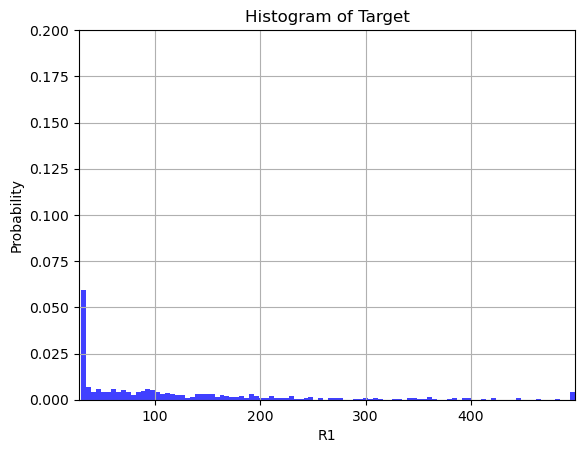

In [25]:
n, bins, patches = plt.hist(data_real['R'], bins=100,density=True, facecolor = "blue",alpha=0.75)


plt.xlabel('R1')
plt.ylabel('Probability')
plt.title('Histogram of Target')
plt.xlim(np.min(data_real['R']-2), np.max(data_real['R']))
plt.ylim(0, 0.2)
plt.grid(True)
plt.show()

#  Quantile Off Policy Evaluation

When facing sequential decision-making problems, it is of particular interest to evaluate the performance of applying a given policy on the agent. In real settings, we are interested in evaluating the outcome of some fixed policy $\pi$, i.e. the target policy, while the data we have is often offline and collected from another potentially different policy $b$, i.e. the behavior policy. 

[Xu et al. 2022 [3]](https://arxiv.org/abs/2212.14466) proposed a doubly-robust inference procedure for quantile off-policy evaluation (OPE) in sequential decision making and study its asymptotic properties. In particular, the state-of-the-art deep conditional generative learning methods were conducted to handle parameter-dependent nuisance function estimation. 



##  Main idea
The doubly robust estimator of quantile estimation is
\begin{equation}
    \hat{\eta}_n=\arg\min_{\eta} \frac{1}{n}\sum_{i=1}^n\left[\frac{C(A_i,X_i)}{\hat{K}_C(X_i)}\rho_{\tau}(Y_i-\eta)+\left(1-\frac{C(A_i,X_i)}{\hat{K}_C(X_i)}\right)\hat{\mathbb{E}}[\rho_{\tau}(\hat{Y}-\eta)|X=X_i,A=\pi(X_i)]\right],
\end{equation}
where $\hat{K}_C(X)=\hat{b}(X)\pi(X)+(1-\hat{b}(X))(1-\pi(X))$, and 
\begin{equation*}
    \hat{\mathbb{E}}[\rho_{\tau}(\hat{Y}-\eta)|A=\pi(X_i),X=X_i]=\frac{1}{M}\sum_{j=1}^M \rho(\hat{Y}_j-\eta),
\end{equation*}
in which $\{\hat{Y}_j\}_{j=1}^M$ are the random outcomes we generated from some estimated data generating model given $X_i$ and policy $\pi$.

In function QDR_QOPE(), $\hat{Y}$ is estimated by Mixture Density Network (MDN), and the propensity score is estimated by Gradient Boosting Decision Tree (GBDT). To futher reduce the bias of the quanatile estimator, 5-folds cross fitting was also implemented by default.




Next, we will use both the simulation data and a real dataset to illustrate the performance of Quantile Off Policy Evaluation.



## Demo on Simulation data

In [ ]:
from causaldm.learners.CPL13.disc.DR_QuantileOPE import *
def pi(X):
    return 1 # all-1 policy
Quantile_OTR=QuantileOPE()
QOPE_est=Quantile_OTR.QDR_QOPE(data=data_sim, pi = pi,tau=0.5)

fold:  0
fold:  1
fold:  2
fold:  3
fold:  4


In [ ]:
QOPE_est # estimated quantile value at level tau for a given target policy pi

2.927600463556344

## Demo on Real dataset

In [ ]:
# initialize the learner
Quantile_OTR=QuantileOPE()
def pi(X):
    return 1 # all-1 policy

QOPE_est=Quantile_OTR.QDR_QOPE(data=data_real, pi = pi, tau=0.5)

In [ ]:
QOPE_est # estimated quantile value at level tau for a given target policy $\pi$

77.5961404868027

### Reference


    [1] Lan Wang, Yu Zhou, Rui Song and Ben Sherwood. "Quantile-Optimal Treatment Regimes." Journal of the American Statistical Association 2018; 113(523): 1243–1254.

    [2] Moodie, Erica EM, Nema Dean, and Yue Ru Sun. "Q-learning: Flexible learning about useful utilities." Statistics in Biosciences 6 (2014): 223-243.
    
    [3] Xu, Y., Shi, C., Luo, S., Wang, L., & Song, R. (2022). Quantile Off-Policy Evaluation via Deep Conditional Generative Learning. arXiv preprint arXiv:2212.14466.
